In [1]:
import numpy as np
import nibabel as nib
import os
from skimage.transform import resize
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### custom dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

## Load and Preprocess Data

In [4]:
data_dir = '/content/drive/My Drive/medical_datasets/'
train_dir = os.path.join(data_dir, 'imagesTr')
test_dir = os.path.join(data_dir, 'imagesTs')
label_dir = os.path.join(data_dir, 'labelsTr')

In [5]:
train_image_files = sorted([os.path.join(train_dir, file) for file in os.listdir(train_dir) if file.endswith(".nii")])
test_image_files = sorted([os.path.join(test_dir, file) for file in os.listdir(test_dir) if file.endswith(".nii")])
label_files = sorted([os.path.join(label_dir, file) for file in os.listdir(label_dir) if file.endswith(".nii")])

In [6]:
def load_data(image_files, label_files, target_shape=(256, 256)):
    images = []
    labels = []
    for image_file, label_file in zip(image_files, label_files):
        image_data = nib.load(image_file).get_fdata()
        label_data = nib.load(label_file).get_fdata()
        slice_index = image_data.shape[2] // 2

        image_slice = image_data[:, :, slice_index]
        label_slice = label_data[:, :, slice_index]

        image_slice = resize(image_slice, target_shape, anti_aliasing=True)
        label_slice = resize(label_slice, target_shape, anti_aliasing=False, preserve_range=True)

        images.append(image_slice)
        labels.append(label_slice)

    return np.array(images), np.array(labels)

In [7]:
train_images, train_labels = load_data(train_image_files, label_files)
test_images, test_labels = load_data(test_image_files, label_files)

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_images, train_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#for images, labels in train_loader:
#    pass
#for images, labels in test_loader:
#    pass

In [8]:
print("Train Images Shapes:")
for img in train_images:
    print(img.shape)

print("Train Labels Shapes:")
for lbl in train_labels:
    print(lbl.shape)

print("Test Images Shapes:")
for img in test_images:
    print(img.shape)

print("Test Labels Shapes:")
for lbl in test_labels:
    print(lbl.shape)

Train Images Shapes:
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
Train Labels Shapes:
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
Test Images Shapes:
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
Test Labels Shapes:
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


In [9]:
train_images, train_labels = load_data(train_image_files[:5], label_files[:5])

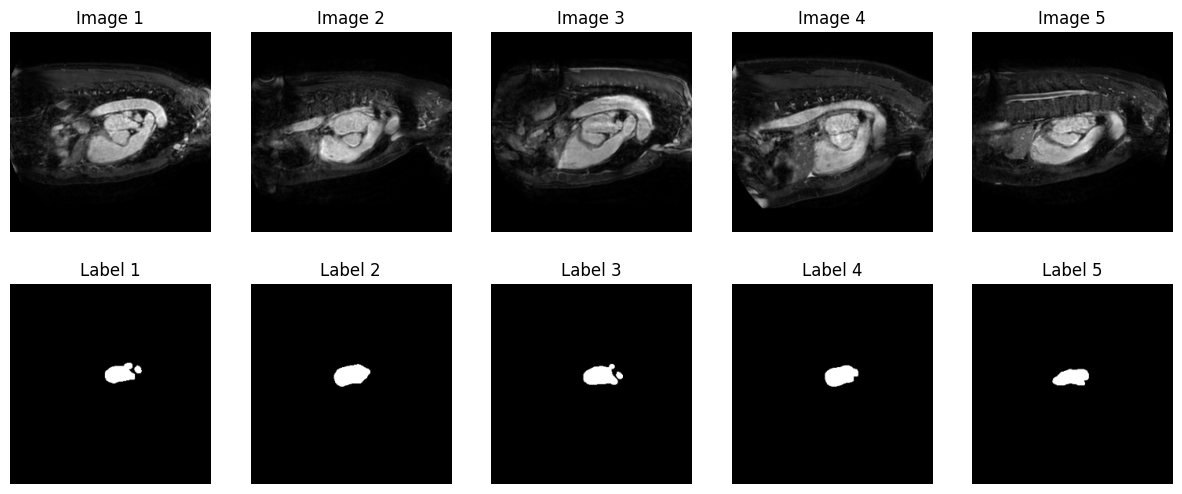

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(train_images[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Image {}'.format(i+1))
    axes[1, i].imshow(train_labels[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Label {}'.format(i+1))
plt.show()

### UNet Architecture
- encoder : reduce the spatial dimensions of the input image while increasing the number of feature channels.
- decoder : upsample the feature maps back to the original spatial dimensions of the input image.

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),  # ReLU activation added here
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)  # ReLU activation added here
        )

    def forward(self, x):
        return self.conv_op(x)


In [13]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [14]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

### Test the model

In [15]:
import matplotlib.pyplot as plt

def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device).float()  # Ensure input data is float32
            labels = labels.to(device).float()  # Ensure labels are float32

            outputs = model(images)
            # Perform any necessary post-processing on outputs
            # For example, you might apply softmax if you're using cross-entropy loss
            # Or apply a threshold to convert logits to binary predictions
            # Then calculate metrics like Dice coefficient or IoU
            # For simplicity, let's print the images and labels here
            for i in range(images.shape[0]):
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Input Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(labels[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Ground Truth Label')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(outputs[i].cpu().numpy().squeeze(), cmap='gray')
                plt.title('Predicted Output')
                plt.axis('off')

                plt.show()


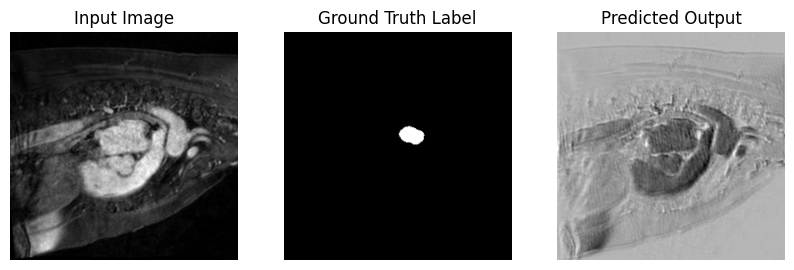

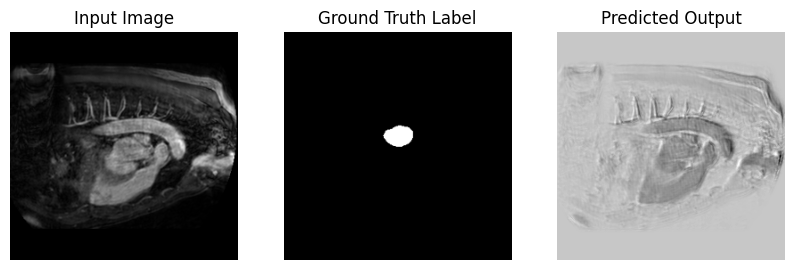

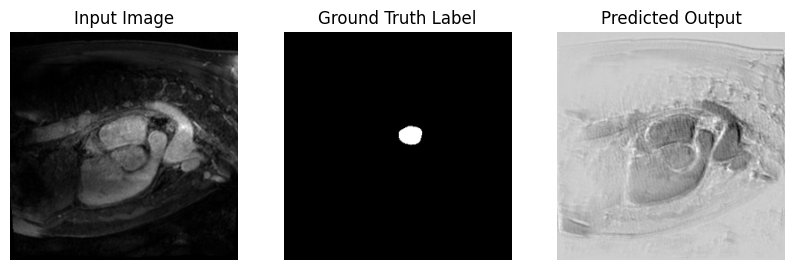

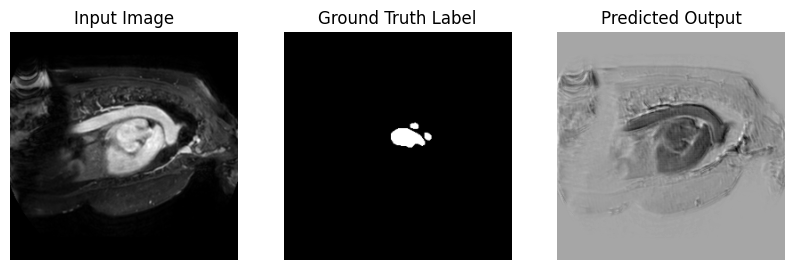

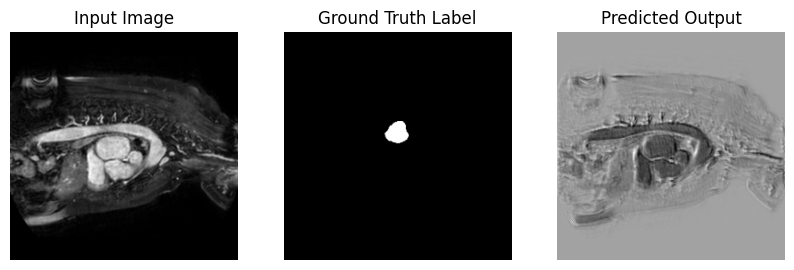

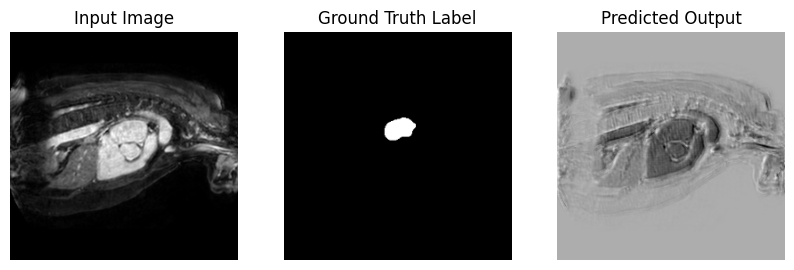

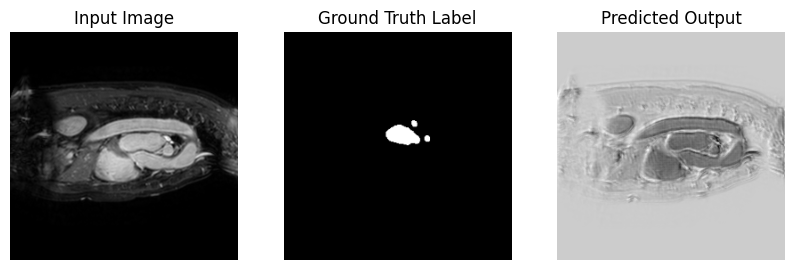

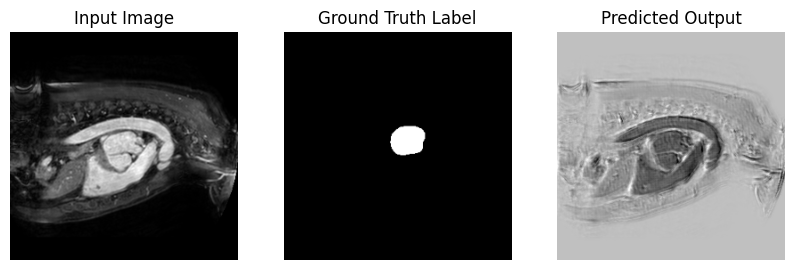

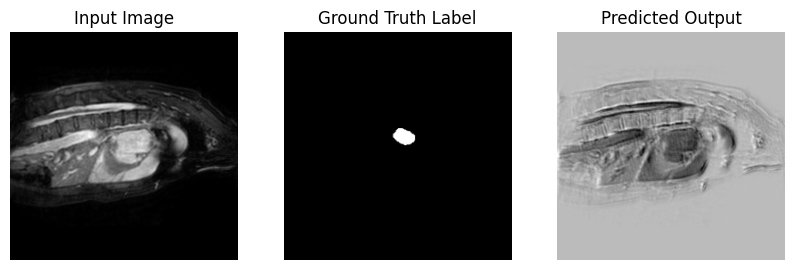

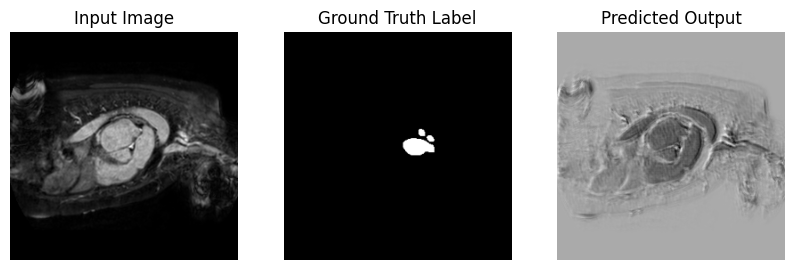

In [17]:
model = UNet(in_channels=1, num_classes=1)  # Assuming grayscale images and binary segmentation
test_model(model, test_loader)

### Model Training - Hyperparameters

In [18]:
train_images_tensor = torch.tensor(train_images).unsqueeze(1).float()
train_labels_tensor = torch.tensor(train_labels).unsqueeze(1).float()

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = UNet(in_channels=1, num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [25]:
num_epochs = 2500
batch_size = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i in range(0, len(train_images_tensor), batch_size):
        inputs = train_images_tensor[i:i+batch_size].to(device)
        labels = train_labels_tensor[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_images_tensor)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

Epoch [1/2500], Loss: 0.0010
Epoch [2/2500], Loss: 0.0010
Epoch [3/2500], Loss: 0.0010
Epoch [4/2500], Loss: 0.0010
Epoch [5/2500], Loss: 0.0010
Epoch [6/2500], Loss: 0.0010
Epoch [7/2500], Loss: 0.0010
Epoch [8/2500], Loss: 0.0010
Epoch [9/2500], Loss: 0.0010
Epoch [10/2500], Loss: 0.0010
Epoch [11/2500], Loss: 0.0010
Epoch [12/2500], Loss: 0.0010
Epoch [13/2500], Loss: 0.0010
Epoch [14/2500], Loss: 0.0010
Epoch [15/2500], Loss: 0.0010
Epoch [16/2500], Loss: 0.0010
Epoch [17/2500], Loss: 0.0010
Epoch [18/2500], Loss: 0.0010
Epoch [19/2500], Loss: 0.0010
Epoch [20/2500], Loss: 0.0010
Epoch [21/2500], Loss: 0.0010
Epoch [22/2500], Loss: 0.0010
Epoch [23/2500], Loss: 0.0010
Epoch [24/2500], Loss: 0.0010
Epoch [25/2500], Loss: 0.0010
Epoch [26/2500], Loss: 0.0010
Epoch [27/2500], Loss: 0.0010
Epoch [28/2500], Loss: 0.0010
Epoch [29/2500], Loss: 0.0010
Epoch [30/2500], Loss: 0.0010
Epoch [31/2500], Loss: 0.0010
Epoch [32/2500], Loss: 0.0010
Epoch [33/2500], Loss: 0.0010
Epoch [34/2500], Lo

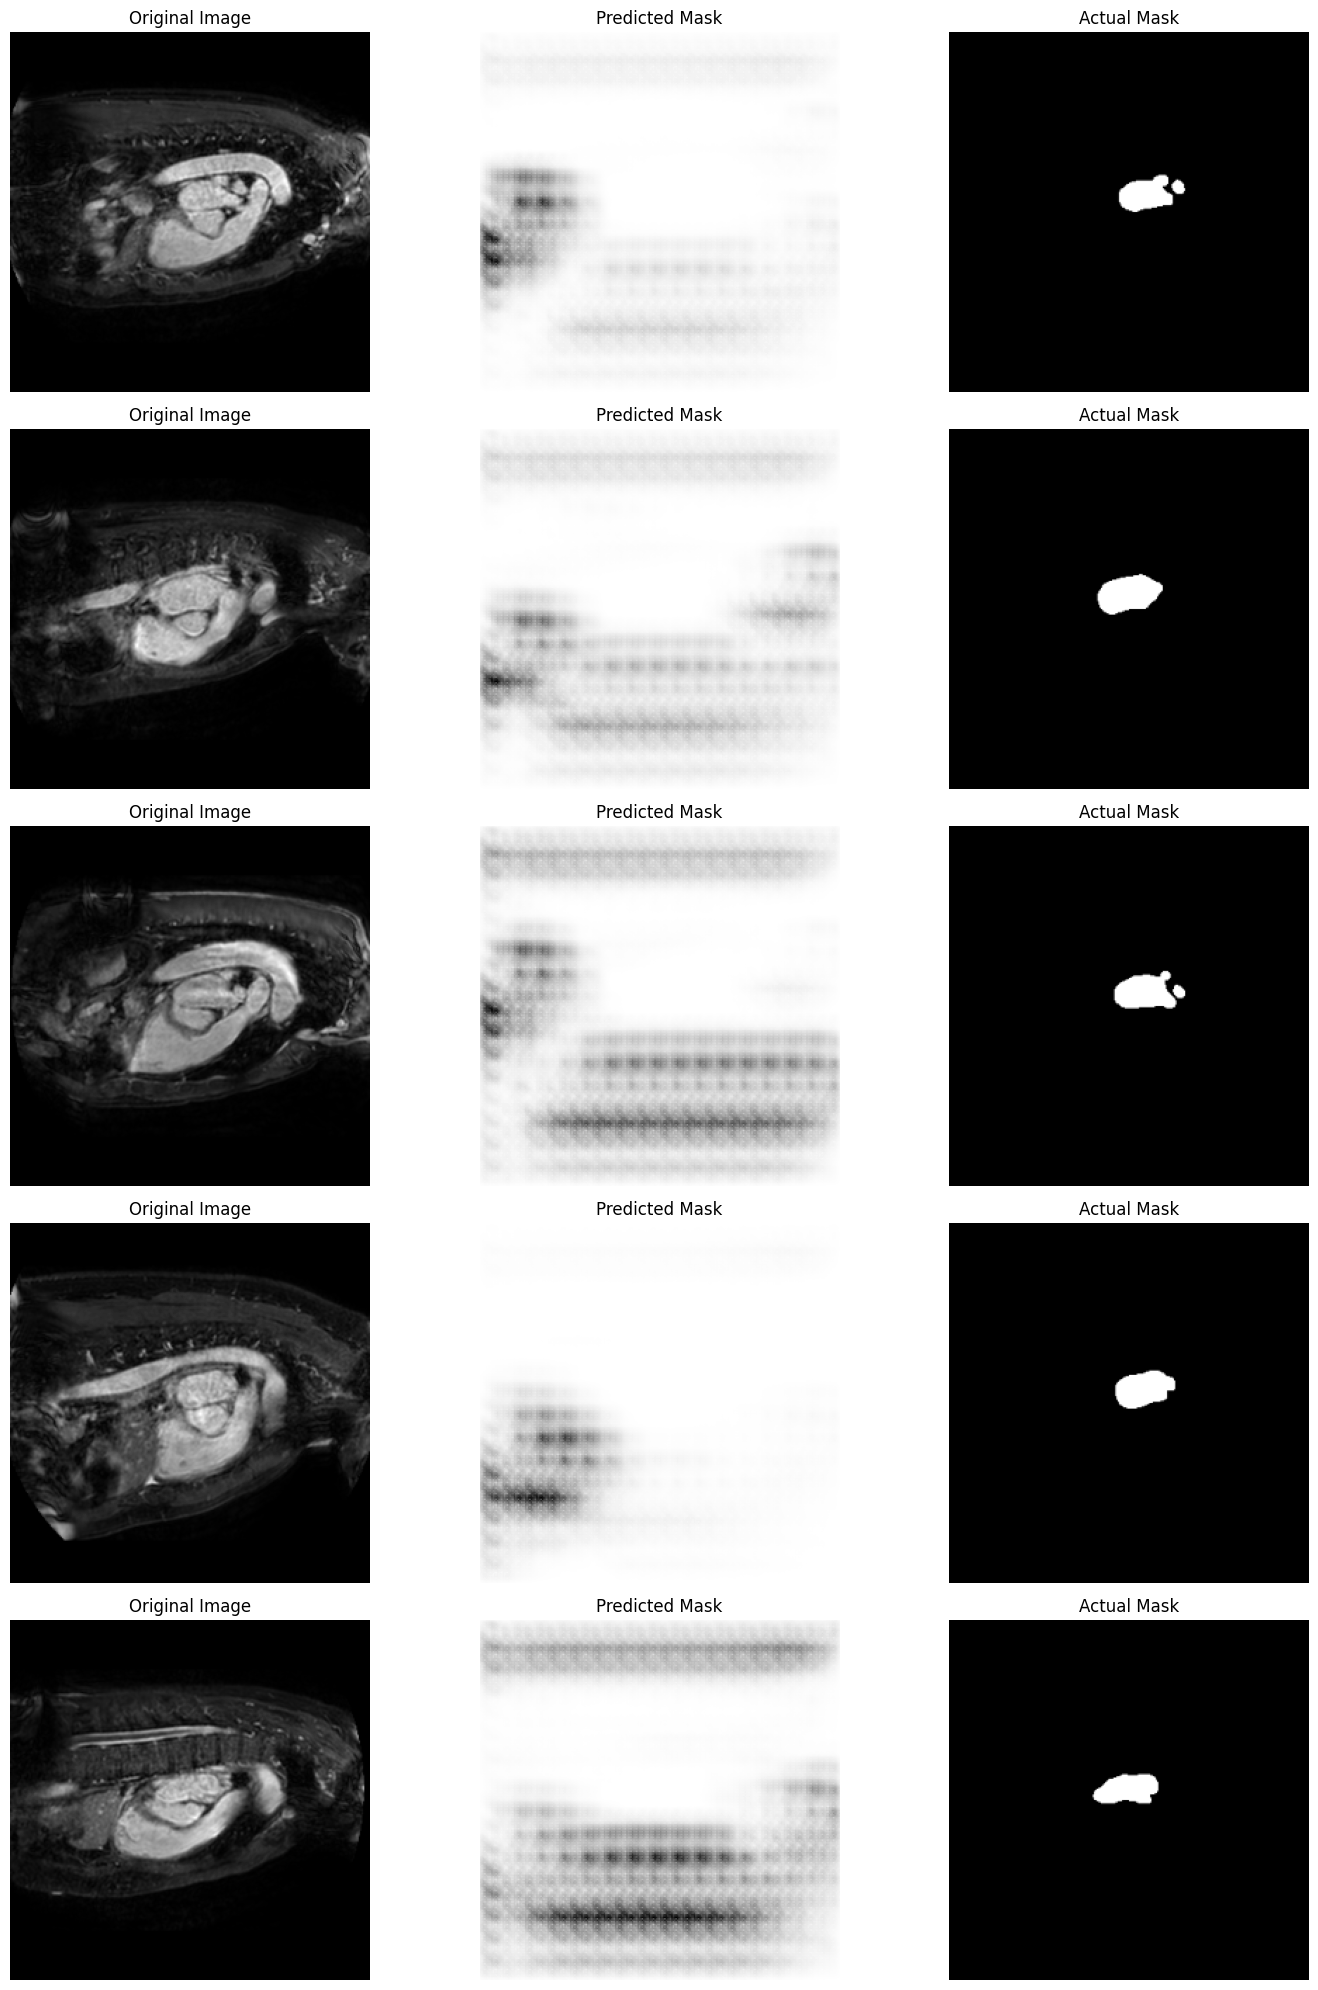

In [26]:
model.eval()
with torch.no_grad():
    outputs = model(train_images_tensor.to(device))
predicted_masks = outputs.cpu().detach().numpy()
num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 20))

for i in range(num_samples):
    axes[i, 0].imshow(train_images[i], cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(predicted_masks[i][0], cmap='gray')
    axes[i, 1].set_title('Predicted Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(train_labels[i], cmap='gray')
    axes[i, 2].set_title('Actual Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


### Another Code to Test

Epoch [1/10], Loss: 0.0010
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


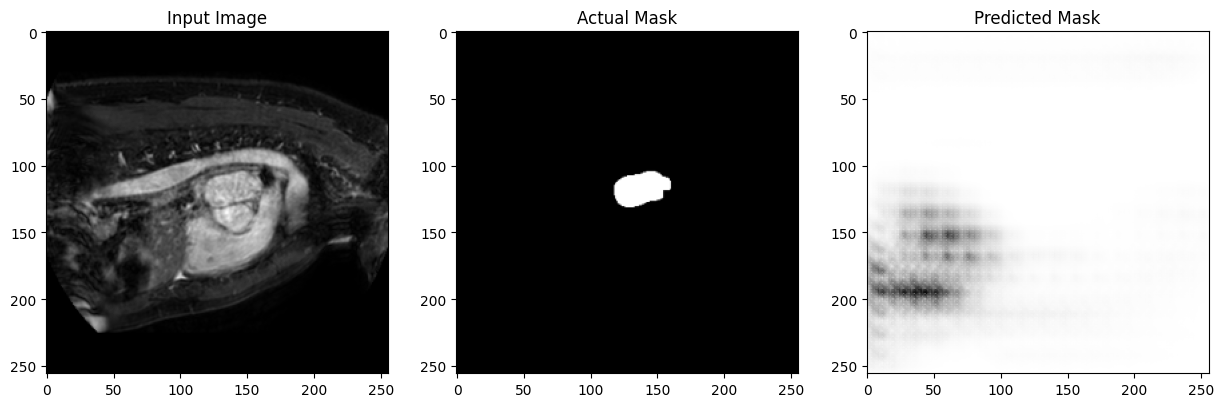

Epoch [2/10], Loss: 0.0010
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


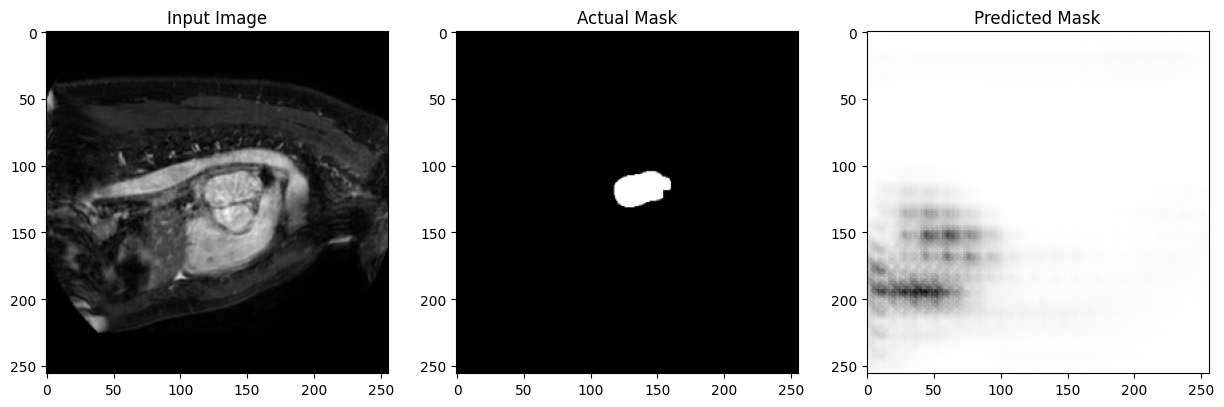

Epoch [3/10], Loss: 0.0010
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


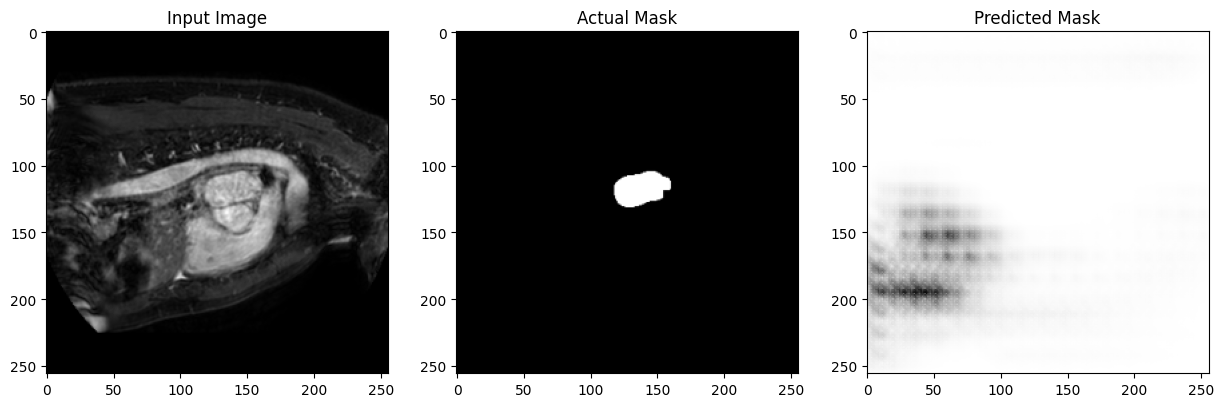

Epoch [4/10], Loss: 0.0010
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


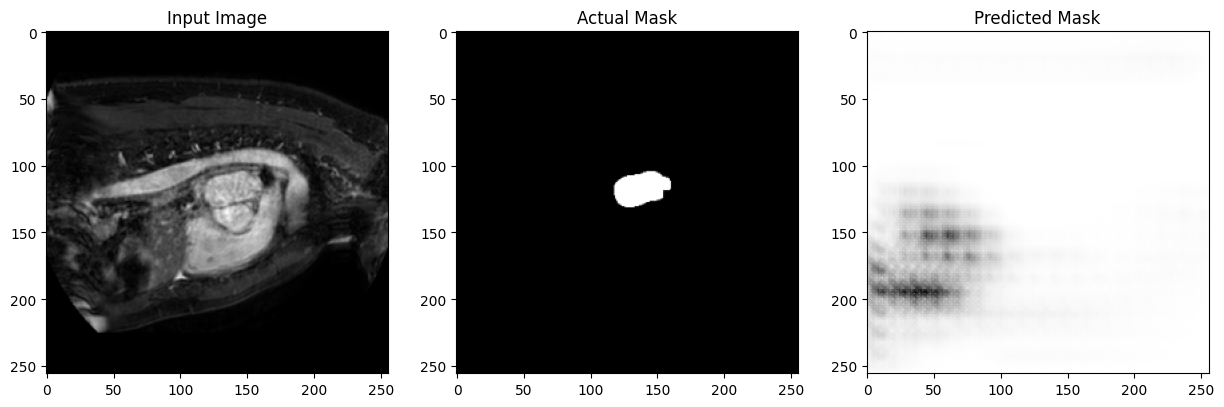

Epoch [5/10], Loss: 0.0010
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


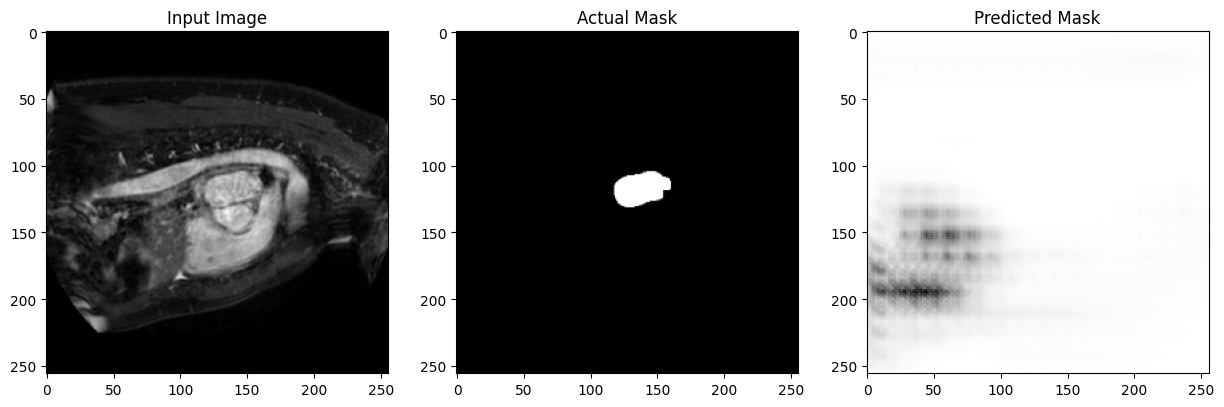

Epoch [6/10], Loss: 0.0011
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


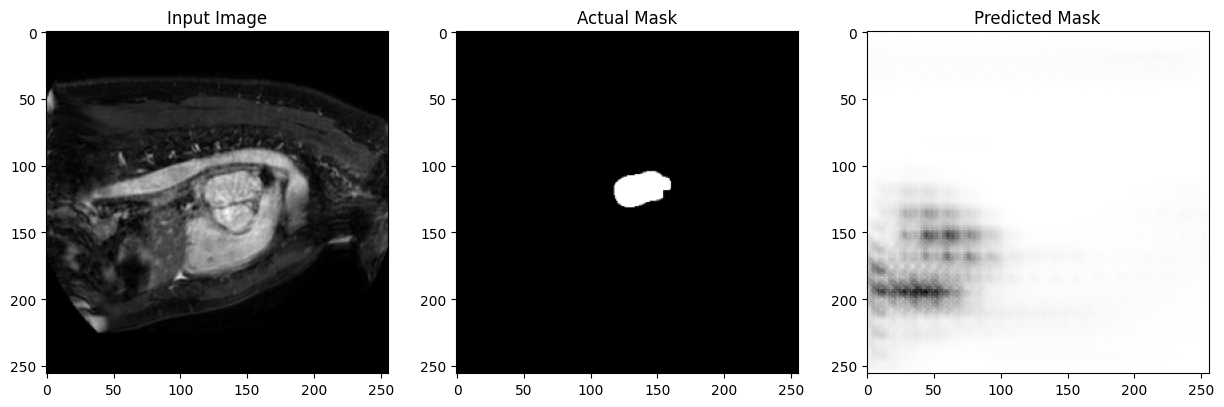

Epoch [7/10], Loss: 0.0012
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


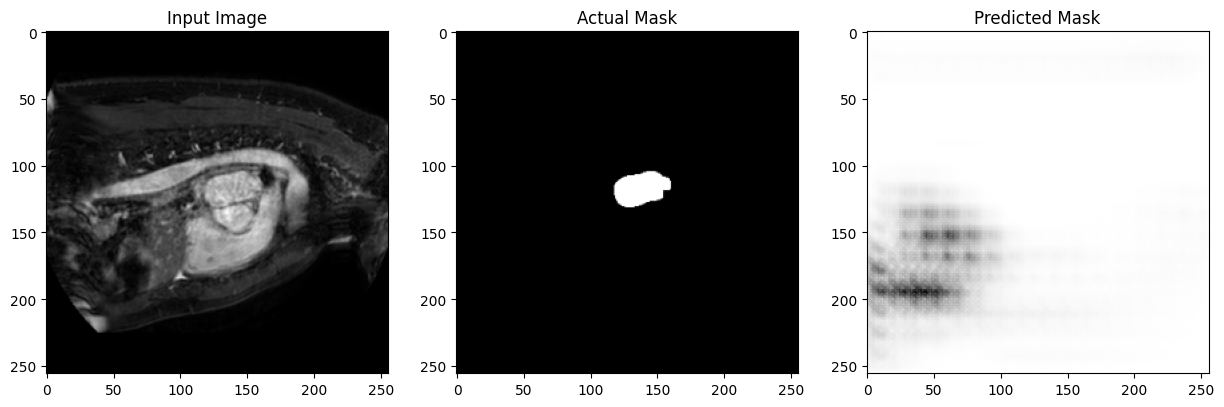

Epoch [8/10], Loss: 0.0018
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


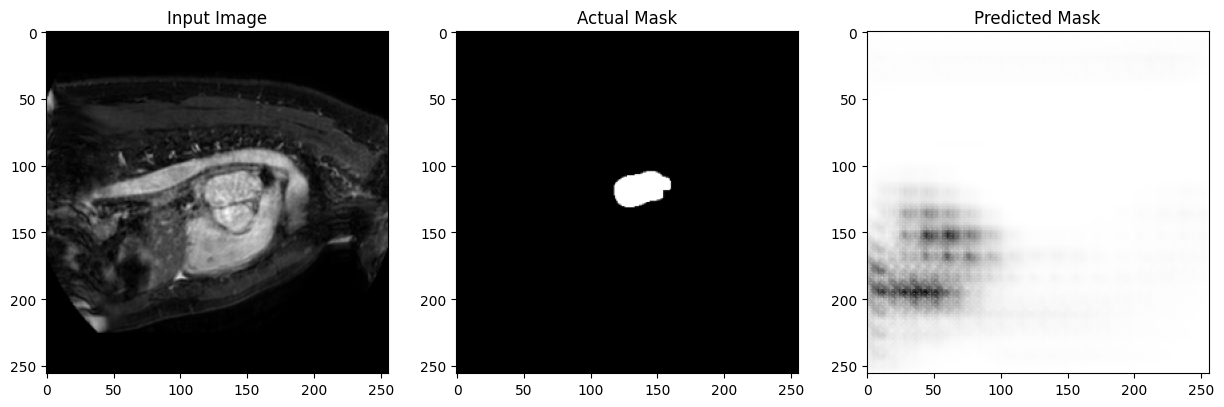

Epoch [9/10], Loss: 0.0049
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


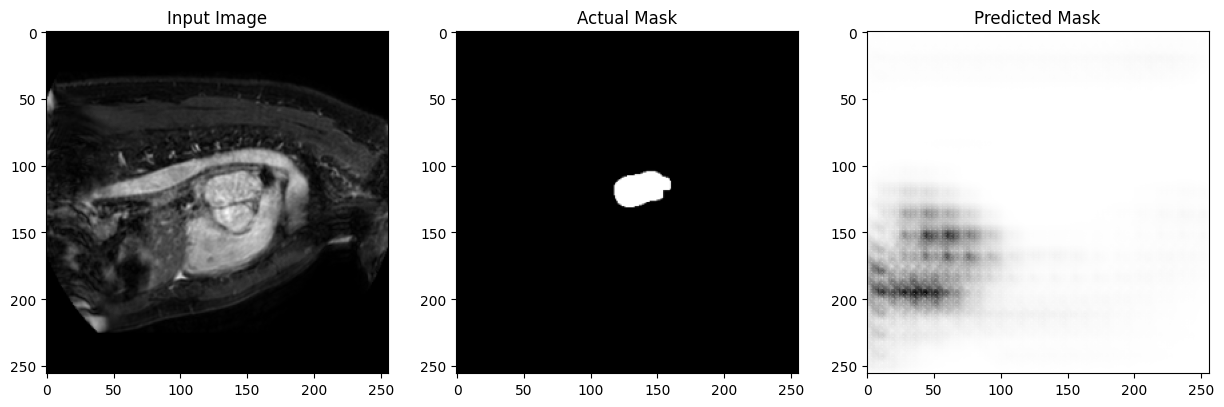

Epoch [10/10], Loss: 0.0022
Sample input shape: torch.Size([2, 1, 256, 256])
Sample label shape: torch.Size([2, 1, 256, 256])
Sample output shape: torch.Size([2, 1, 256, 256])


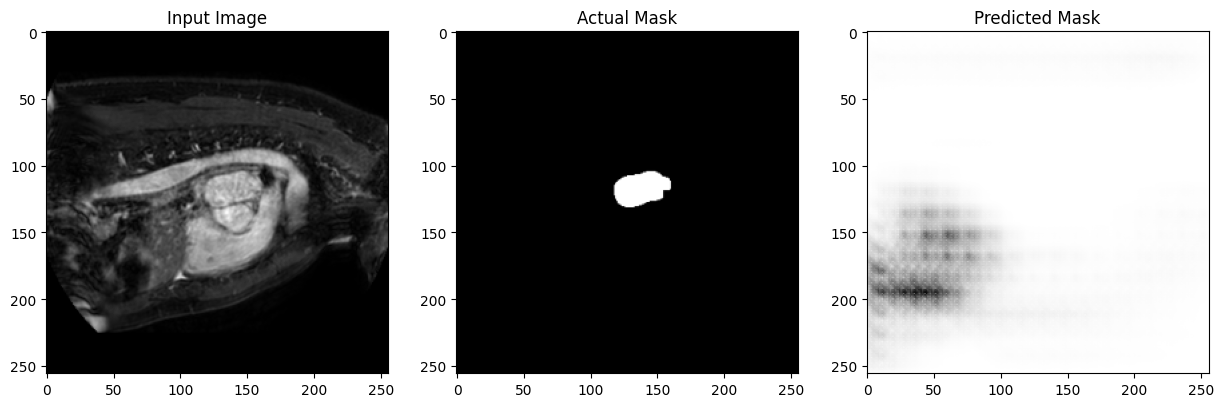

In [29]:
num_epochs = 10
batch_size = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i in range(0, len(train_images_tensor), batch_size):
        inputs = train_images_tensor[i:i+batch_size].to(device)
        labels = train_labels_tensor[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_images_tensor)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

    # Debugging print statements
    print("Sample input shape:", inputs.shape)
    print("Sample label shape:", labels.shape)
    print("Sample output shape:", outputs.shape)

    # Visualize a sample input, label, and output
    sample_index = 0
    sample_input = inputs[sample_index].cpu().detach().numpy().squeeze()
    sample_label = labels[sample_index].cpu().detach().numpy().squeeze()
    sample_output = outputs[sample_index].cpu().detach().numpy().squeeze()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(sample_input, cmap='gray')
    plt.title("Input Image")
    plt.subplot(1, 3, 2)
    plt.imshow(sample_label, cmap='gray')
    plt.title("Actual Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(sample_output, cmap='gray')
    plt.title("Predicted Mask")
    plt.show()
